## Parse results and create tables and figures

This notebook can be uses to visualize the results. 

The results are in the csv inside smartbugs and non_smartbugs. 

Two csv files, 'all_results_RSD_src.csv' and  'all_results_AGGREGATED_src.csv' contain the results of all tools for the datasets. 

Change filename in the cell below to select which results to display. 

The only exception is Vandal, which requires the binary of the contracts. As when a file .sol contains n contracts it is compiled into n different binary files, the results are not comparable

In [ ]:
import pandas as pd
from io import StringIO
from sklearn.metrics import f1_score


# Read data from the CSV file and select only the required columns.


filename = 'all_results_RSD_bins.csv' # results for the RSD - Vandal only works on bins
filename = 'all_results_AGGREGATED_bins.csv'# results for the Aggregated Benchmark - Vandal only works on bins

filename = 'all_results_RSD_src.csv' # results for the RSD
filename = 'all_results_AGGREGATED_src.csv'# results for the Aggregated Benchmark


if 'src' in filename:
    out_csv = 'reentrancy_metrics_data_src.csv'
    latex_file = 'latex_table_src.csv'
    aggregated_file = 'aggregated_results_src.csv'
    input
else:
    out_csv = 'reentrancy_metrics_data_bins.csv'
    latex_file = 'latex_table_bins.csv'
    aggregated_file = 'aggregated_results_bins.csv'
df = pd.read_csv(filename)
df = df[['filename', 'basename', 'exit_code', 'toolid', 'findings']]
# print(df)
df['exit_code'] = df['exit_code'].fillna(-1).astype(int)
print(df.shape)
df = df[~df['basename'].str.contains('Human')]
print(df.shape)
if 'src' in filename:
    df = df[df['filename'].str.contains('safe|ree', na=False)]


# A dictionary mapping each tool to the string(s) it produces for a reentrancy finding.
# You can easily update this dictionary as needed. For tools with multiple labels,
# use a comma-separated string, e.g., 'tool_name': 'label1,label2'.
reentrancy_labels = {
    'aderyn': 'Reentrancy',
    'ccc': 'Reentrancy_Vulnerability',
    'confuzzius': 'Reentrancy',
    'conkas': 'Reentrancy', #.sol 0.5
    'ethor-2023': 'insecure',
    #'manticore-0.3.7': 'Reentrancy', # placeholder
    'mythril-0.24.7': 'State_access_after_external_call_SWC_107',
    'oyente+-2acaf2e': 'Re_Entrancy_Vulnerability',
    'oyente+-060ca34':'Re_Entrancy_Vulnerability',
    'sailfish': 'dao',
    'securify': 'DAO_', 
    'securify2': 'Reentrancy', # does not work
    'sfuzz': 'Reentrancy', 
    'slither-0.11.3': 'reentrancy_eth,reentrancy_no_eth',
    #'smartcheck': 'Reentrancy', # never finds any occurrence of reentrancy
    'solhint-6.0.0': 'reentrancy',
    #'ethainter': 'Reentrancy', # does not work
    'vandal': 'ReentrantCall',
    'gpt-oss': 'reentrant',
    'gpt-5-mini': 'reentrant',
    'gpt-5': 'reentrant',
    'gpt-5-nano': 'reentrant'
    }

# 1. Determine the "true" reentrancy label for each file based on its filename.
# 'ree' followed by an optional number indicates a true reentrancy vulnerability.
df['true_reentrancy'] = df['filename'].str.contains(r'ree', case=False)

# 2. Determine the "predicted" reentrancy label based on the 'findings' column.
# This function will check if any of the tool-specific reentrancy labels are present in the findings.
def get_prediction(row):
    tool_id = row['toolid']
    findings = str(row['findings']) # Convert to string to handle potential NaN values

    # Check if the tool is in our labels dictionary.
    if tool_id in reentrancy_labels:
        # Split the tool's finding string into a list of individual labels.
        tool_findings = [f.strip() for f in reentrancy_labels[tool_id].split(',')]
        
        # Check if any of the tool's labels are present in the findings from the data.
        for label in tool_findings:
            if label in findings:
                return True
    return False

df['predicted_reentrancy'] = df.apply(get_prediction, axis=1)


# 3. Calculate metrics for each unique tool and print only the results.
# Analyze only the tools present in the reentrancy_labels dictionary.
tools_to_analyze = reentrancy_labels.keys()
good_tools = []
print("Reentrancy Metrics per Tool:")
print("=" * 30)

print('Tool, Accuracy, Precision, Recall, F1 Score, Errors')
for tool in tools_to_analyze:

    # Filter the DataFrame for the current tool.
    tool_df = df[df['toolid'] == tool]

    n_results = tool_df.shape[0]

    ERRORS = (tool_df['exit_code'] != 0).sum()

    ERRORS2  = tool_df[(tool_df['exit_code'] != 0) & (tool_df['findings'] == '{}')].shape[0]/n_results if n_results >0 else 0

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).
    TP = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == True)])
    FP = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == True)])
    TN = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == False)])
    FN = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == False)])
    # print(TP, FP, TN, FN)
    
    # Calculate Accuracy, Precision, and Recall.
    # Handle cases where the denominator is zero to avoid errors.
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    
    # Precision: Out of all positive predictions, how many were correct?
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: Out of all actual positives, how many were correctly predicted?
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate the F1 Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    #f1_score = f1_score(tool_df['true_reentrancy'], tool_df['predicted_reentrancy'], zero_division=0, average = 'weighted')
    if f1_score > 0:
        good_tools.append(tool)
        print(f"{tool}, {accuracy:.2f}, {precision:.2f}, {recall:.2f}, {f1_score:.2f}, {ERRORS2*100:.2f}" )
        # print(f"  Accuracy:  {accuracy*100:.2f}")
        # print(f"  Precision: {precision*100:.2f}")
        # print(f"  Recall:    {recall*100:.2f}")
        # print(f"  F1 Score:  {f1_score*100:.2f}")
        # #print(f"  Errors: {ERRORS}")
        # print(f"  Errors: {ERRORS2*100:.2f}")
        # print("-" * 30)

print(df.shape)
df = df[(df['exit_code'] == 0) | ((df['exit_code'] != 0) & (df['findings'] != '{}'))]
print(df.shape)
# Save the DataFrame to a new CSV file.
filtered_df = df[df['toolid'].isin(good_tools)]
filtered_df.to_csv(out_csv, index=False)
print(f"\nSaved CSV with only tools that found something → {out_csv}")

(2310, 5)
(2145, 5)
Reentrancy Metrics per Tool:
Tool, Accuracy, Precision, Recall, F1 Score, Errors
aderyn, 0.66, 0.62, 0.79, 0.70, 0.00
ccc, 0.58, 0.74, 0.24, 0.36, 0.00
confuzzius, 0.58, 0.57, 0.61, 0.59, 12.59
mythril-0.24.7, 0.67, 0.67, 0.66, 0.67, 0.00
oyente+-060ca34, 0.60, 0.72, 0.32, 0.45, 0.00
slither-0.11.3, 0.74, 0.71, 0.82, 0.76, 0.00
solhint-6.0.0, 0.55, 0.59, 0.28, 0.38, 0.00
(2145, 7)
(1692, 7)

Saved CSV with only tools that found something → reentrancy_metrics_data_src.csv


Compute metrics according to the csv just created.

In [38]:
import pandas as pd

df = filtered_df.copy()

# Group predictions per contract
grouped = df.groupby("basename")

# Find the ones where true_reentrancy is True
true_re = grouped.first()
true_re = true_re[true_re["true_reentrancy"] == True]

# Count correct detections per contract
# A correct detection = predicted_reentrancy == true_reentrancy == True
correct_count = grouped["predicted_reentrancy"].sum()

# Keep only contracts where exactly N tool detects TRUE
hard_cases = correct_count[(correct_count == 8)]

# Get the rows from df for these contracts to inspect
results = df[df["basename"].isin(hard_cases.index)]

print(f"Contracts with TRUE reentrancy where only ONE tool is correct: {len(hard_cases)}")

# results.sort_values(["basename", "toolid"])


Contracts with TRUE reentrancy where only ONE tool is correct: 0


In [16]:

# Load data
df_loc = pd.read_csv("contracts_loc.csv")
df_re = pd.read_csv(out_csv)

# Remove version from names and capitalize
df_re["toolid"] = df_re["toolid"].str.split("-").str[0].str.capitalize()

# # Keep only the best tools
# tools_keep = ["Slither", "Mythril", "Aderyn", "Oyente+"]
# df_re = df_re[df_re["toolid"].isin(tools_keep)].copy()



# Normalize strings
df_loc["contract_name"] = df_loc["contract_name"].str.strip()
df_re["basename"] = df_re["basename"].str.strip()

# Create a lookup dictionary: {contract_name: loc}
loc_map = dict(zip(df_loc["contract_name"], df_loc["loc"]))

# Add the LOC column based on basename
df_re["loc"] = df_re["basename"].map(loc_map)

# Show rows that did NOT find a match
missing = df_re[df_re["loc"].isna()]["basename"].unique()
print(f"Contracts with NO LOC match: {len(missing)}")
for m in missing:
    print(" -", m)

df_re


Contracts with NO LOC match: 79
 - 00_BasicInline_ree1.sol
 - 00_BasicInline_safe1.sol
 - 01_SingleMutexFoldUnderflow_ree1.sol
 - 01_SingleMutexFoldUnderflow_safe1.sol
 - 02_CrossMutexUnderflow_ree1.sol
 - 02_CrossMutexUnderflow_safe1.sol
 - 03_SingleModFoldUnderflow_ree1.sol
 - 03_SingleModFoldUnderflow_safe1.sol
 - 03_SingleModUnderflow_ree1.sol
 - 03_SingleModUnderflow_safe1.sol
 - 04_CrossModFoldUnderflow_safe1.sol
 - 05_SendEmitUnchecked_safe1.sol
 - 05_SendEmit_safe1.sol
 - 05_SendUnchecked_safe1.sol
 - 05_Send_safe1.sol
 - 05_Send_safe2.sol
 - 05_Send_safe3.sol
 - 06_TransferUnchecked_safe1.sol
 - 06_TransferUnchecked_safe2.sol
 - 06_Transfer_safe1.sol
 - 06_Transfer_safe2.sol
 - 07_MixedSendFoldEmit_ree1.sol
 - 07_MixedSendFoldEmit_safe1.sol
 - 07_MixedSendFold_ree1.sol
 - 07_MixedSendFold_safe1.sol
 - 07_MixedSend_ree1.sol
 - 07_MixedSend_safe1.sol
 - 08_MixedTransferEmit_ree1.sol
 - 08_MixedTransferEmit_safe1.sol
 - 08_MixedTransfer_ree1.sol
 - 08_MixedTransfer_safe1.sol
 - 0

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
0,src/00_BasicCall_ree1.sol,00_BasicCall_ree1.sol,0,Ccc,{},True,False,14.0
1,src/00_BasicCall_safe1.sol,00_BasicCall_safe1.sol,0,Ccc,{},False,False,14.0
2,src/00_BasicConst_ree1.sol,00_BasicConst_ree1.sol,0,Ccc,{},True,False,15.0
3,src/00_BasicConst_safe1.sol,00_BasicConst_safe1.sol,0,Ccc,{},False,False,15.0
4,src/00_BasicCross_ree1.sol,00_BasicCross_ree1.sol,0,Ccc,{Message_padding_vulnerability_found_at_ether_...,True,False,19.0
...,...,...,...,...,...,...,...,...
978,src/15_ReadOnlyStaticcall_ree1.sol,15_ReadOnlyStaticcall_ree1.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN
979,src/15_ReadOnlyStaticcall_safe1.sol,15_ReadOnlyStaticcall_safe1.sol,0,Aderyn,[],False,False,NaN
980,src/15_ReadOnly_ree1.sol,15_ReadOnly_ree1.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN
981,src/15_ReadOnly_ree2.sol,15_ReadOnly_ree2.sol,0,Aderyn,"[{""severity"":""high"",""title"":""Reentrancy: State...",True,True,NaN


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# df_re must contain: toolid, loc, predicted_reentrancy

plt.figure(figsize=(16, 6))

tools = sorted(df_re["toolid"].unique())

# For each tool we create two x positions:
# left cluster  = predicted False
# right cluster = predicted True
x_base = {tool: i for i, tool in enumerate(tools)}

# width of separation between the two groups per tool
offset = 0.25

for tool in tools:
    subset = df_re[df_re["toolid"] == tool]
    base = x_base[tool]

    # FALSE group (orange)
    false_group = subset[subset["predicted_reentrancy"] == False]
    x_false = np.full(len(false_group), base - offset)
    x_false_jitter = x_false + np.random.normal(0, 0.05, size=len(false_group))

    plt.scatter(
        x_false_jitter,
        false_group["loc"],
        c="orange",
        s=20,
        alpha=0.7,
        label="False positives" if tool == tools[0] else None
    )

    # TRUE group (green)
    true_group = subset[subset["predicted_reentrancy"] == True]
    x_true = np.full(len(true_group), base + offset)
    x_true_jitter = x_true + np.random.normal(0, 0.05, size=len(true_group))

    plt.scatter(
        x_true_jitter,
        true_group["loc"],
        c="green",
        s=20,
        alpha=0.7,
        label="True positives" if tool == tools[0] else None
    )

# X-axis tick labels centered between groups
plt.xticks(range(len(tools)), tools)
# plt.yscale("log")

plt.xlabel("Tool ID")
plt.ylabel("Lines of Code (LOC)")
plt.title("Predicted Reentrancy by Tool vs LOC (Separated Groups + Jitter)")
plt.legend()
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors



df = df_re.copy()

# ----------------------------------------------------
# 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# ----------------------------------------------------
unique_points = df["basename"].unique()
n = len(unique_points)
cmap = cm.get_cmap('tab20', len(unique_points))
colors = {}
x_jitter = {}
y_jitter = {}

np.random.seed(42)
np.random.shuffle(unique_points)  # <-- THIS changes color ordering

for i, name in enumerate(unique_points):
    # evenly spaced colors on the HSV color wheel
    hue = i / n
    colors[name] = plt.cm.hsv(hue)[:3]  # convert to RGB

    x_jitter[name] = np.random.normal(0, 0.15)
    y_jitter[name] = np.random.normal(0, 0.05)

# ----------------------------------------------------
# 2. Build X-axis groups: tool_FALSE, tool_TRUE
# ----------------------------------------------------
tools = sorted(df["toolid"].unique())

x_labels = []
x_positions = {}
pos = 0

for tool in tools:
    x_positions[(tool, False)] = pos
    x_labels.append(f"{tool}\nFALSE")
    pos += 1
    
    x_positions[(tool, True)] = pos
    x_labels.append(f"{tool}\nTRUE")
    pos += 1

# ----------------------------------------------------
# 3. PLOT — fixed jitter X + fixed jitter Y
# ----------------------------------------------------
plt.figure(figsize=(18, 7))

for _, row in df.iterrows():
    label = row['true_reentrancy']
    name = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    if label != pred:
        # FIXED jitter per datapoint
        x = x_positions[(tool, pred)]# + x_jitter[name]
        y = loc + y_jitter[name] * loc  # keep jitter proportional but linear


        plt.scatter(
            x,
            y,
            c=[colors[name]],
            s=8,
            alpha=0.8,
            edgecolor="black",
            linewidth=0.4
        )
        plt.text(
            x ,
            y ,
            name,
            fontsize=10,
            ha='center',
            va='center',
            alpha=0.9,
            # rotation=55
        )

# ----------------------------------------------------
# 4. Formatting
# ----------------------------------------------------
# plt.yscale("log")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
plt.ylabel("Lines of Code (LOC)", fontsize=20)
plt.title("Misclassified Contracts for the best tools on the RSD", fontsize=25)
plt.ylim(bottom=10, top=39)
xmin, xmax = plt.xlim()

plt.xlim(xmin-0.1, xmax + 0.1)


plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig("misclassified.pdf", bbox_inches="tight")
plt.show()


C:\Users\ressi\AppData\Local\Temp\ipykernel_11100\628994632.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = pivot.fillna(False).astype(bool)
C:\Users\ressi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perf

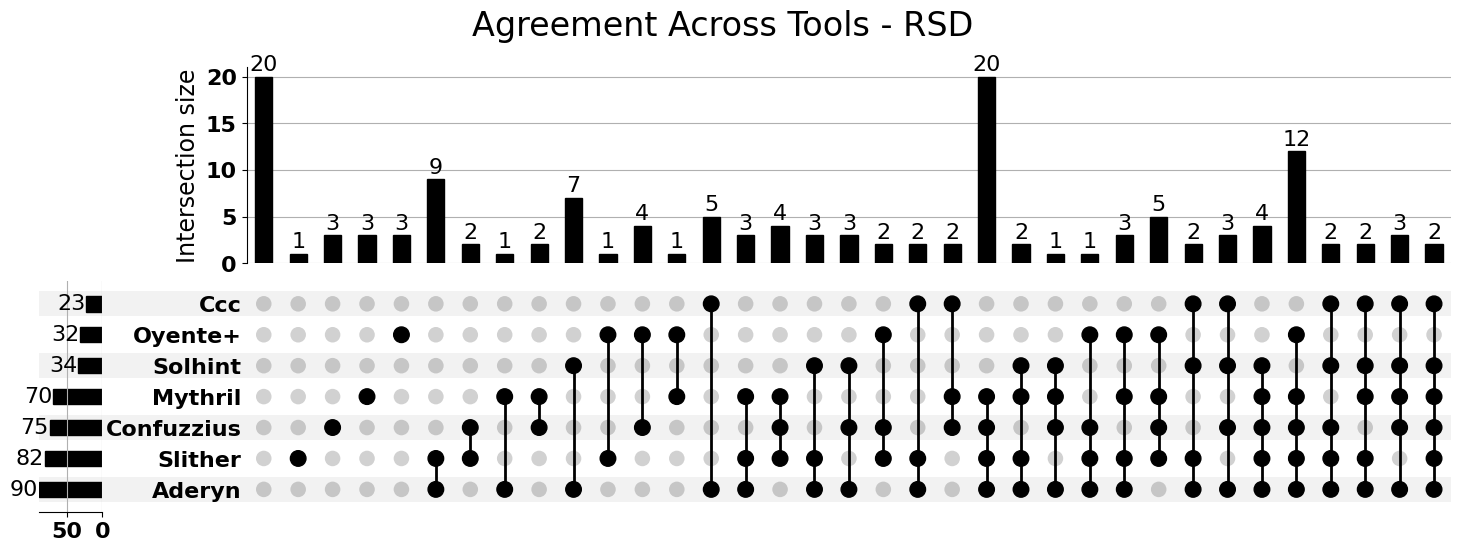

In [31]:
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

df = df_re.copy()

pivot = df.pivot_table(
    index="basename",
    columns="toolid",
    values="predicted_reentrancy",
    aggfunc="first"
)

pivot = pivot.fillna(False).astype(bool)
upset_data = from_indicators(pivot)

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

fig = plt.figure(figsize=(20, 8))

u = UpSet(
    upset_data,
    subset_size="count",
    # orientation="vertical",   # <--- VERTICAL (important)
    show_counts=True,
    #sort_by='cardinality',
    # element_size=40,
    min_subset_size=1
    
)

u.plot(fig=fig)

for ax in fig.axes:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(16)   # <--- adjust this value as you like
        label.set_fontweight("bold")
for ax in fig.axes:
    for t in ax.texts:
        content = t.get_text()
        # Check if it's a number (subset size or bar count)
        if content.isdigit():
            t.set_fontsize(16)   # <--- CHANGE FONT SIZE HERE
            # t.set_fontweight("bold")

for ax in fig.axes:
    if ax.get_ylabel() == "Intersection size":
        ax.set_ylabel("Intersection size", fontsize=17)  # <-- QUI


# add title AFTER plot
fig.suptitle("Agreement Across Tools - RSD", fontsize= 24)#, y=1.02)
# fig.suptitle("Agreement Across Tools - Aggregated Benchmark", fontsize= 26)#, y=1.02)

# Adjust top margin so title stays outside
# fig.subplots_adjust(top=0.998)

fig.savefig("upset_plot_RSD_full.pdf", bbox_inches="tight")
# fig.savefig("upset_plot_RSD.pdf", bbox_inches="tight")
plt.show()


In [33]:
import pandas as pd

df = df_re.copy()

# Tools to include
tools_to_show = ["slither", "mythril", "aderyn", "Oyente+"]  # <-- best performers
df = df[df["toolid"].isin(tools_to_show)]

# Dizionario: results[tool]["FALSE"], results[tool]["TRUE"]
results = {}

# Creiamo la struttura
for tool in df["toolid"].unique():
    results[tool] = {"FALSE": [], "TRUE": []}

# Riempimento
for _, row in df.iterrows():
    tool = row["toolid"]
    name = row["basename"]
    true = row["true_reentrancy"]
    pred = row["predicted_reentrancy"]

    if true != pred:   # errore
        if pred is False:
            results[tool]["FALSE"].append(name)
        else:
            results[tool]["TRUE"].append(name)


# ----------------------------------------------------
for tool in results:
    print(f"\n================ {tool.upper()} ================")
    print(" Predicted FALSE but should be TRUE:")
    for c in results[tool]["FALSE"]:
        print("   -", c)

    print("\n Predicted TRUE but should be FALSE:")
    for c in results[tool]["TRUE"]:
        print("   -", c)



================ OYENTE+ ================
 Predicted FALSE but should be TRUE:
   - 00_BasicInline_ree1.sol
   - 01_SingleMutexFoldUnderflow_ree1.sol
   - 01_SingleMutexFold_ree1.sol
   - 01_SingleMutexFold_ree2.sol
   - 01_SingleMutex_ree2.sol
   - 02_CrossMutexUnchecked_ree1.sol
   - 02_CrossMutexUnderflow_ree1.sol
   - 02_CrossMutex_ree1.sol
   - 03_SingleModFoldUnderflow_ree1.sol
   - 03_SingleModUnderflow_ree1.sol
   - 03_SingleMod_ree3.sol
   - 04_CrossModFold_ree1.sol
   - 04_CrossMod_ree1.sol
   - 04_CrossMod_ree5.sol
   - 07_MixedSendFoldEmit_ree1.sol
   - 07_MixedSendFold_ree1.sol
   - 07_MixedSend_ree1.sol
   - 08_MixedTransferEmit_ree1.sol
   - 08_MixedTransfer_ree1.sol
   - 09_ERC20InheritMod_ree1.sol
   - 09_ERC20InheritMod_ree2.sol
   - 09_ERC20InheritMod_ree3.sol
   - 09_ERC20Inherit_ree1.sol
   - 09_ERC20Mod_ree1.sol
   - 09_ERC20Mod_ree2.sol
   - 09_ERC20Mod_ree3.sol
   - 09_ERC20OnlyOnce_ree1.sol
   - 09_ERC20StakingPullMod_ree1.sol
   - 09_ERC20StakingPullMod_ree2.

In [34]:
df = df_re.copy()

# ----------------------------------------------
# 1. Normalize tool ids (remove versions, capitalize)
# ----------------------------------------------
def clean_toolid(t):
    t = t.split("-")[0]   # remove version after '-'
    t = t.strip()
    return t.capitalize()

df["tool_clean"] = df["toolid"].apply(clean_toolid)

# ----------------------------------------------
# 2. List of tools to show
# ----------------------------------------------
tools_to_show = ["Slither", "Mythril", "Aderyn", "Oyente+"]  # capitalized

# ----------------------------------------------
# 3.For each tool: list of TRUE/FALSE errors
# ----------------------------------------------
mistakes = {}

for tool in tools_to_show:
    sub = df[df["tool_clean"] == tool]

    false_group = sub[(sub["predicted_reentrancy"] == False) & (sub["true_reentrancy"] == True)]["basename"].tolist()
    true_group  = sub[(sub["predicted_reentrancy"] == True)  & (sub["true_reentrancy"] == False)]["basename"].tolist()

    mistakes[tool] = {
        "FALSE_when_TRUE": false_group,
        "TRUE_when_FALSE": true_group,
    }

# ----------------------------------------------
# 4. Print results
# ----------------------------------------------
for tool in tools_to_show:
    print("="*50)
    print(f"Tool: {tool}")
    print("- Predicted FALSE but were TRUE:")
    print(mistakes[tool]["FALSE_when_TRUE"])
    print("- Predicted TRUE but were FALSE:")
    print(mistakes[tool]["TRUE_when_FALSE"])


Tool: Slither
- Predicted FALSE but were TRUE:
['00_BasicInline_ree1.sol', '09_ERC20InheritMod_ree2.sol', '09_ERC20InheritMod_ree3.sol', '09_ERC20Mod_ree2.sol', '09_ERC20Mod_ree3.sol', '09_ERC20Staking_ree3.sol', '14_DelegateCall_ree1.sol', '14_DelegateCall_ree2.sol', '14_DelegateCall_ree3.sol', '14_DelegateCall_ree4.sol', '15_ReadOnlyStaticcall_ree1.sol', '15_ReadOnly_ree1.sol', '15_ReadOnly_ree2.sol']
- Predicted TRUE but were FALSE:
['01_SingleMutexFoldUnderflow_safe1.sol', '01_SingleMutexFold_safe1.sol', '01_SingleMutex_safe1.sol', '01_SingleMutex_safe2.sol', '02_CrossMutexUnchecked_safe1.sol', '02_CrossMutexUnderflow_safe1.sol', '02_CrossMutex_safe1.sol', '02_CrossMutex_safe2.sol', '03_SingleModFoldUnderflow_safe1.sol', '03_SingleModFold_safe1.sol', '03_SingleModUnderflow_safe1.sol', '03_SingleMod_safe1.sol', '04_CrossModFoldUnderflow_safe1.sol', '04_CrossModFold_safe1.sol', '04_CrossMod_safe2.sol', '04_CrossMod_safe3.sol', '09_ERC20OnlyOnce_safe1.sol', '09_ERC20StakingPullMod_saf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

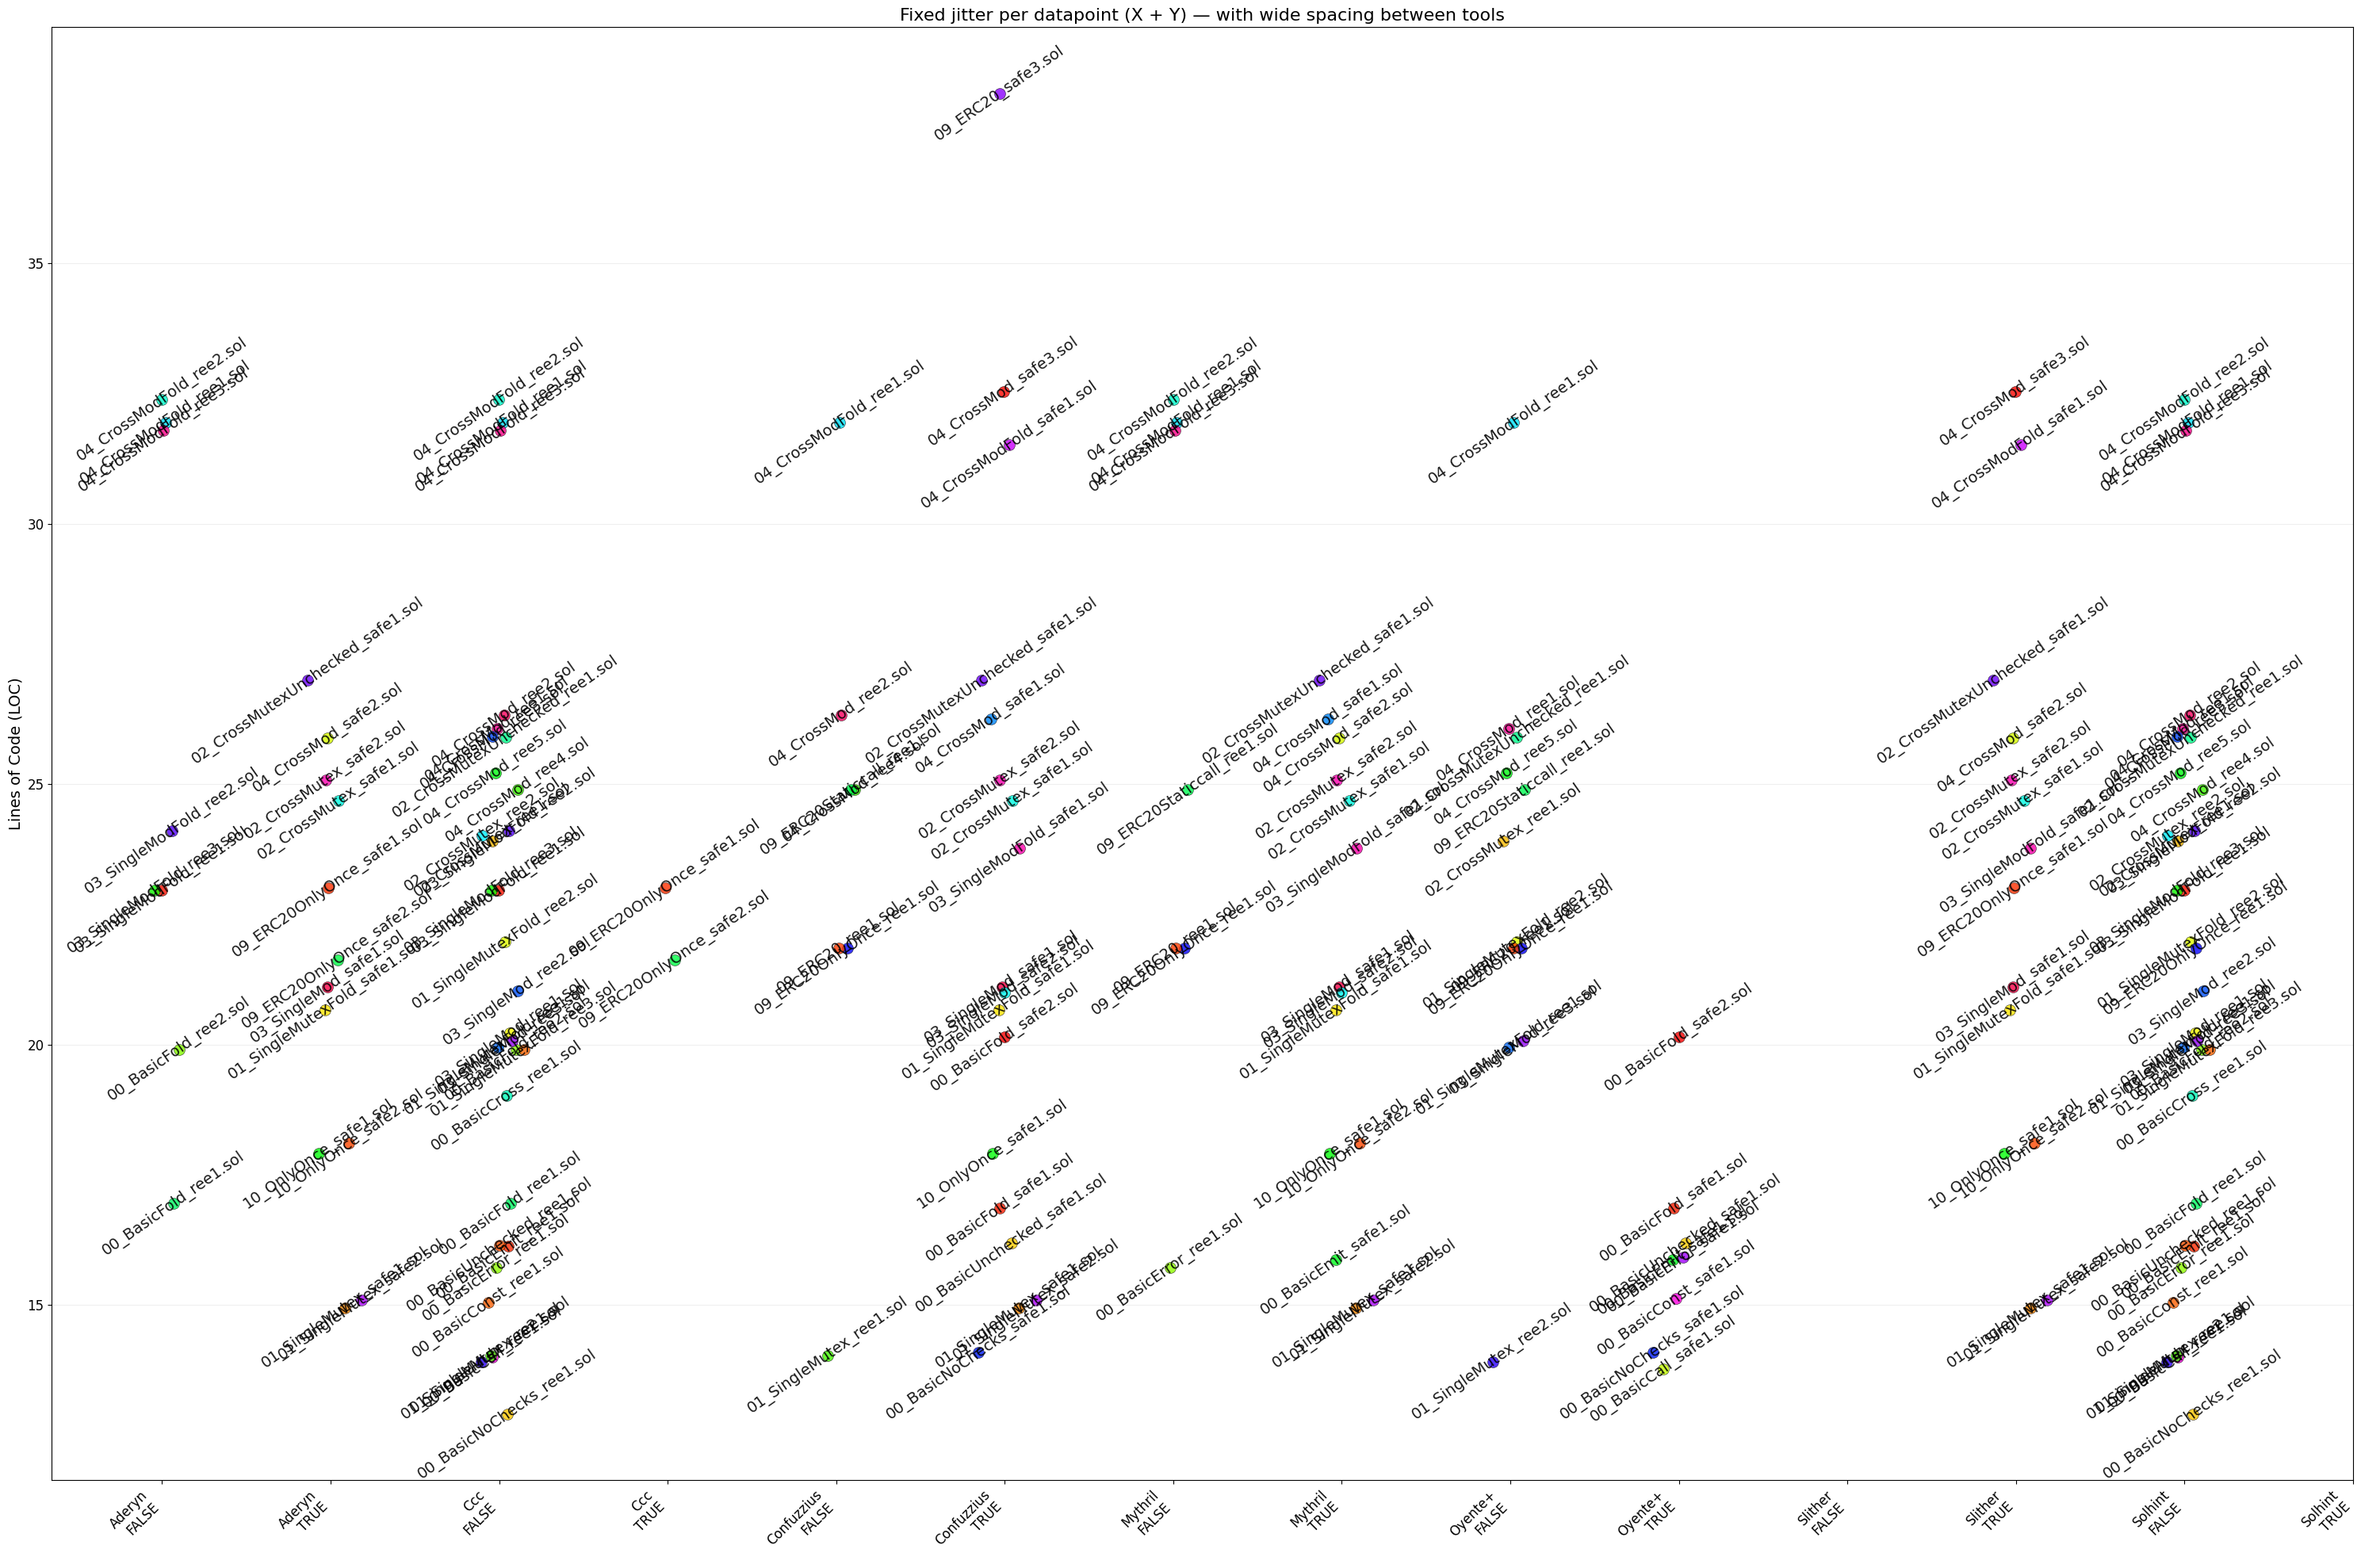

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

df = df_re.copy()

# ----------------------------------------------------
# 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# ----------------------------------------------------
unique_points = df["basename"].unique()
n = len(unique_points)

colors = {}
x_jitter = {}
y_jitter = {}

np.random.seed(4)
np.random.shuffle(unique_points)  # ensures color variety

for i, name in enumerate(unique_points):
    hue = i / n
    colors[name] = plt.cm.hsv(hue)[:3]  # stable RGB
    x_jitter[name] = np.random.normal(0, 0.4)
    y_jitter[name] = np.random.normal(0, 0.01)

# ----------------------------------------------------
# 2. Build X-axis groups: tool_FALSE, tool_TRUE
# ----------------------------------------------------
tools = sorted(df["toolid"].unique())

x_labels = []
x_positions = {}

spacing = 6   # <---  increase this to spread groups farther apart

pos = 0
for tool in tools:
    x_positions[(tool, False)] = pos
    x_labels.append(f"{tool}\nFALSE")
    pos += spacing

    x_positions[(tool, True)] = pos
    x_labels.append(f"{tool}\nTRUE")
    pos += spacing

# ----------------------------------------------------
# 3. PLOT — fixed jitter X + fixed jitter Y
# ----------------------------------------------------
plt.figure(figsize=(30, 20))

for _, row in df.iterrows():
    label = row['true_reentrancy']
    name = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    if label != pred:
        x = x_positions[(tool, pred)] + x_jitter[name]
        y = loc + y_jitter[name] * loc

        plt.scatter(
            x,
            y,
            c=[colors[name]],
            s=100,          # bigger balls requested earlier
            alpha=0.8,
            edgecolor="black",
            linewidth=0.4
        )

        plt.text(
            x ,
            y,
            name,
            fontsize=14,
            ha='center',
            va='center',
            alpha=0.9,
            rotation=35
        )

# ----------------------------------------------------
# 4. Formatting
# ----------------------------------------------------
# plt.yscale("log")
plt.xticks([x_positions[key] for key in x_positions], x_labels, rotation=45, ha='right')
plt.ylabel("Lines of Code (LOC)")
plt.title("Fixed jitter per datapoint (X + Y) — with wide spacing between tools")

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

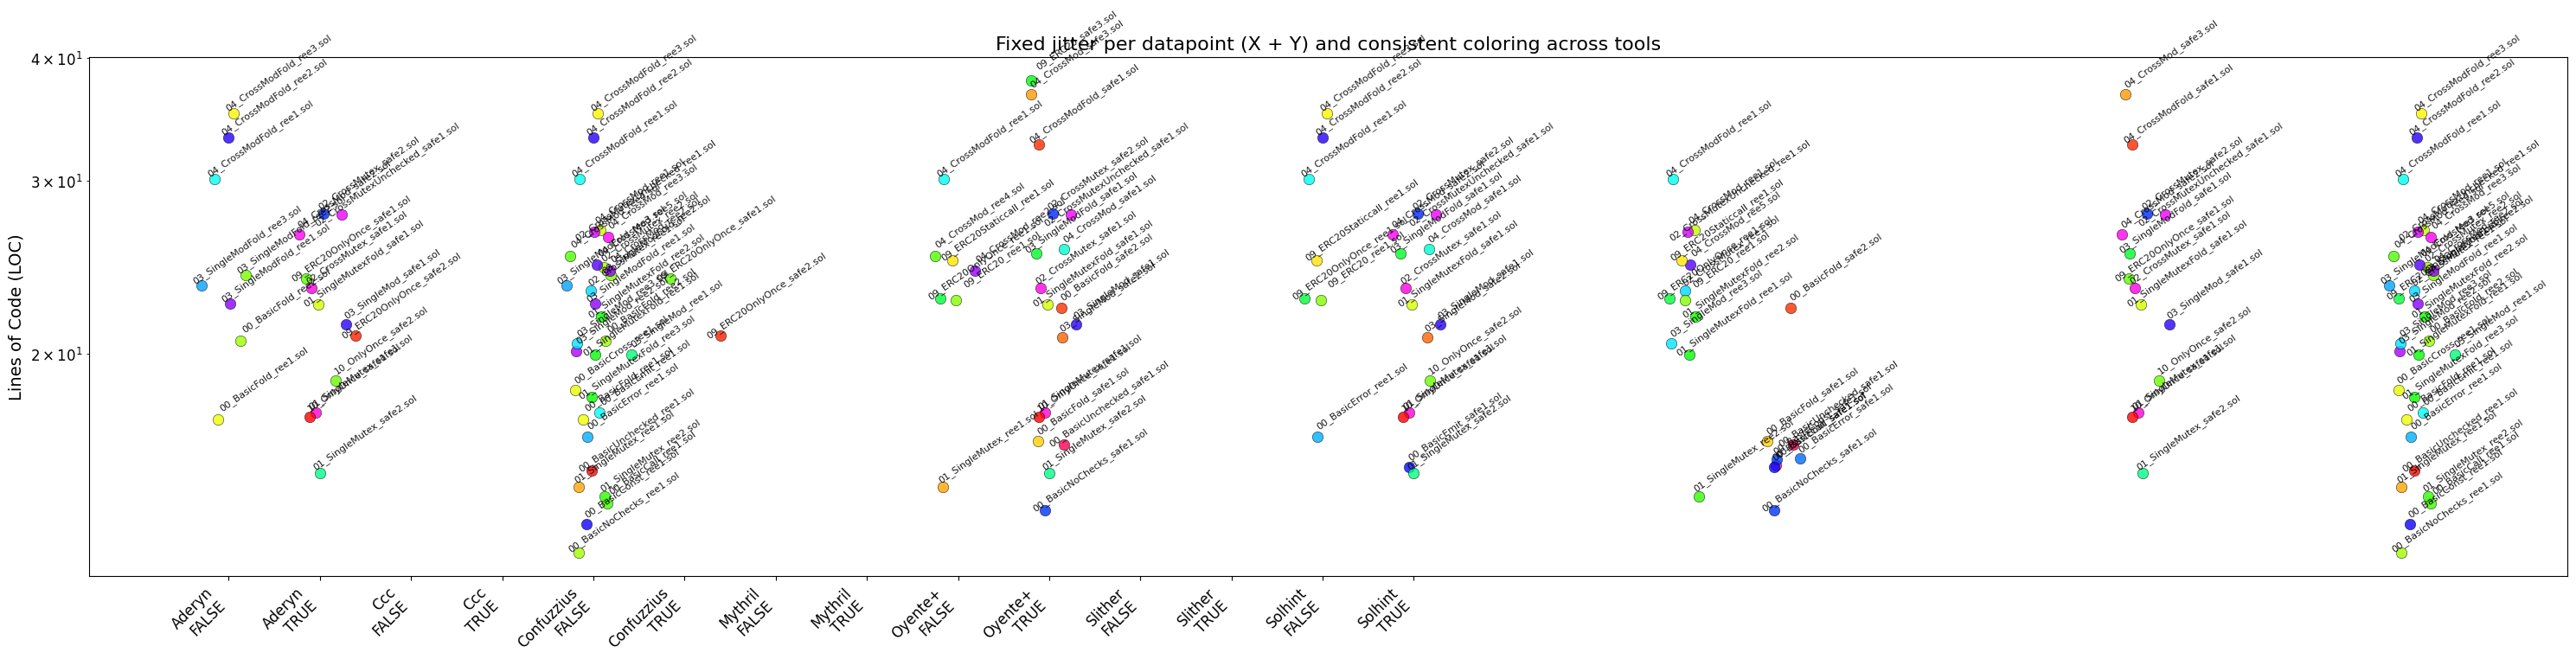

In [37]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# df = df_re.copy()

# # ----------------------------------------------------
# # 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# # ----------------------------------------------------
# unique_points = df["basename"].unique()
# n = len(unique_points)
# colors = {}
# x_jitter = {}
# y_jitter = {}

# np.random.seed(42)
# np.random.shuffle(unique_points)  # <-- ensures colors unrelated to position

# for i, name in enumerate(unique_points):
#     hue = i / n
#     colors[name] = plt.cm.hsv(hue)[:3]

#     x_jitter[name] = np.random.normal(0, 0.15)
#     y_jitter[name] = np.random.normal(0, 0.05)

# # ----------------------------------------------------
# # 2. Build X-axis groups: tool_FALSE, tool_TRUE
# # ----------------------------------------------------
# tools = sorted(df["toolid"].unique())

# group_spacing = 2     # <---- MODIFY THIS to increase horizontal separation
# pos = 0
# x_positions = {}
# x_labels = []

# for tool in tools:
#     # FALSE group
#     x_positions[(tool, False)] = pos
#     x_labels.append(f"{tool}\nFALSE")
#     pos += 1

#     # TRUE group
#     x_positions[(tool, True)] = pos
#     x_labels.append(f"{tool}\nTRUE")
#     pos += 1

#     # ADD SPACING BETWEEN TOOLS
#     pos += group_spacing

# # ----------------------------------------------------
# # 3. PLOT — fixed jitter X + fixed jitter Y
# # ----------------------------------------------------
# plt.figure(figsize=(max(30, len(tools) * 3), 8))

# for _, row in df.iterrows():
#     label = row['true_reentrancy']
#     name = row["basename"]
#     tool = row["toolid"]
#     loc = row["loc"]
#     pred = row["predicted_reentrancy"]

#     if label != pred:
#         x = x_positions[(tool, pred)] + x_jitter[name]
#         y = loc + y_jitter[name] * loc

#         plt.scatter(
#             x,
#             y,
#             c=[colors[name]],
#             s=80,
#             alpha=0.8,
#             edgecolor="black",
#             linewidth=0.4
#         )

#         plt.text(
#             x + 0.5,
#             y * 1.10,
#             name,
#             fontsize=8,
#             ha='center',
#             va='center',
#             alpha=0.9,
#             rotation=35
#         )

# # ----------------------------------------------------
# # 4. Formatting
# # ----------------------------------------------------
# plt.yscale("log")
# plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')

# plt.ylabel("Lines of Code (LOC)")
# plt.title("Fixed jitter per datapoint (X + Y) and consistent coloring across tools")

# plt.grid(axis='y', alpha=0.2)
# plt.tight_layout()
# plt.savefig("misclassified.pdf", bbox_inches="tight")
# plt.show()
